Captum 帮助您了解数据特征如何影响您的模型预测或神经元激活，揭示您的模型如何运作。

使用 Captum，您可以统一应用各种最先进的特征归因算法，例如 Guided GradCam 和 Integrated Gradients。

在这个秘籍中，您将学习如何使用 Captum 来： 
* 将图像分类器的预测归因于它们相应的图像特征。 
* 可视化归因结果。

# 在你开始之前

确保 Captum 安装在活动的 Python 环境中。 Captum 可在 GitHub 上以 pip 包或 conda 包的形式使用。 有关详细说明，请参阅 https://captum.ai/ 上的安装指南

对于模型，我们使用 PyTorch 中的内置图像分类器。 Captum 可以揭示样本图像的哪些部分支持模型做出的某些预测。

In [2]:
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

model = torchvision.models.resnet18(pretrained=True).eval()

response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
img = Image.open(BytesIO(response.content))

center_crop = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
])

normalize = transforms.Compose([
    transforms.ToTensor(),               # converts the image to a tensor with values between 0 and 1
    transforms.Normalize(                # normalize to follow 0-centered imagenet pixel rgb distribution
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
    )
])
input_img = normalize(center_crop(img)).unsqueeze(0)

# 计算归因

在模型的前 3 个预测中是 208 和 283 类，它们对应于狗和猫。

让我们使用 Captum 的遮挡算法将这些预测中的每一个归因于输入的相应部分。

In [6]:
from captum.attr import Occlusion

occlusion = Occlusion(model)

strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
target=208,                       # Labrador index in ImageNet
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_dog = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


target=283,                       # Persian cat index in ImageNet
attribution_cat = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=0)

除了遮挡之外，Captum 还具有许多算法，例如集成梯度、反卷积、GuidedBackprop、GradCam、DeepLift 和 GradientShap。 所有这些算法都是 Attribution 的子类，它期望您的模型在初始化时作为可调用的 forward_func 并具有以统一格式返回归因结果的 attribute(...) 方法。

让我们对图像的计算归因结果进行可视化。

# 可视化结果

Captum 的可视化实用程序提供了开箱即用的方法来可视化图片和文本输入的归因结果。

AttributeError: 'Image' object has no attribute 'shape'

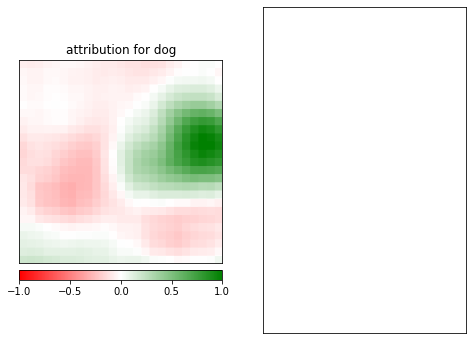

In [7]:
import numpy as np
from captum.attr import visualization as viz

# Convert the compute attribution tensor into an image-like numpy array
attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      center_crop(img),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for dog", "image"],
                                      show_colorbar = True
                                     )


attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cat,
                                      center_crop(img),
                                      ["heat_map", "original_image"],
                                      ["all", "all"], # positive/negative attribution or all
                                      ["attribution for cat", "image"],
                                      show_colorbar = True
                                     )

如果您的数据是文本数据，visualize.visualize_text() 提供了一个专门的视图来探索输入文本之上的属性。 在 http://captum.ai/tutorials/IMDB_TorchText_Interpret 了解更多信息

# 最后的注意点

Captum 可以处理 PyTorch 中的大多数模型类型，包括视觉、文本等。 使用 Captum，您可以： 
* 将特定输出归因于模型输入，如上所示。 
* 将特定输出归因于隐藏层神经元（请参阅 Captum API 参考）。 
* 将隐藏层神经元响应归因于模型输入（参见 Captum API 参考）。

有关支持方法的完整 API 和教程列表，请访问我们的网站 http://captum.ai

Gilbert Tanner 的另一篇有用的帖子：https://gilberttanner.com/blog/interpreting-pytorch-models-with-captum